In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import pickle
from tqdm import tqdm

import librosa, librosa.display
import IPython.display as ipd
from scipy.io import wavfile
from librosa.display import specshow

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch
from sklearn.metrics import f1_score, accuracy_score

### Create DataSet

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def prepare_shape(feature):
  tmp = feature
  N = 128
  while tmp.shape[1] < N:
    tmp = np.hstack((tmp, tmp))
  tmp = tmp[np.newaxis, :, :N]
  return tmp

In [0]:
def load_pkl_data(X_fname, y_fname):
  dir_name = 'drive/My Drive/DCASE2019task4/data/pickle/'
  X = pickle.load(open(dir_name + X_fname, 'rb'))
  y = pickle.load(open(dir_name + y_fname, 'rb'))

  X = np.asarray([prepare_shape(row) for row in X])
  y = np.asarray([row for row in y])

  return X, y

In [0]:
class dataset(Dataset):
  def __init__(self, x, y=None):
    # Случайный сдвиг
    shift = np.random.randint(x.shape[1])
    self.x = np.roll(x, shift, axis=1)
    #self.x = x
    self.y = y
    
  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    if self.y is not None:
        return self.x[idx], self.y[idx]
    return self.x[idx]

In [0]:
classes = {0: "Alarm_bell_ringing", 1: "Speech", 2: "Dog", 3: "Cat", 4: "Vacuum_cleaner", 
           5: "Dishes", 6: "Frying", 7: "Electric_shaver_toothbrush", 8: "Blender", 9: "Running_water"}

X_weak_train, y_weak_train = load_pkl_data('X_weak_train.pkl', 'y_weak_train.pkl')
X_synt_train, y_synt_train = load_pkl_data('X_synthetic_train.pkl', 'y_synthetic_train.pkl')
X_test, y_test = load_pkl_data('X_validation.pkl', 'y_validation.pkl')

X_train = np.vstack((X_weak_train, X_synt_train))
y_train = np.vstack((y_weak_train, y_synt_train))

In [0]:
train_dset = dataset(X_train, y_train)
test_dset = dataset(X_test, y_test)

train_loader = DataLoader(train_dset, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dset, batch_size=64, shuffle=False, num_workers=0)

### Model

In [0]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet,self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        
    self.mp = nn.MaxPool2d(kernel_size=2, stride=2)
    self.globalmp = nn.MaxPool2d(kernel_size=(16,32), stride=1)

    self.dropout = nn.Dropout(p=0.4)

    self.bn1 = nn.BatchNorm2d(num_features=64)
    self.bn2 = nn.BatchNorm2d(num_features=128)
    self.bn3 = nn.BatchNorm2d(num_features=256)
    
    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(256, 10)
        
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = F.relu(x)
    x = self.mp(x)
    x = self.dropout(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = F.relu(x)
    x = self.dropout(x)

    x = self.conv3(x)
    x = self.bn3(x)
    x = F.relu(x)
    x = self.mp(x)

    x = self.globalmp(x)
    x = self.flat(x)
    x = self.fc1(x)
    x = torch.sigmoid(x)
    
    return x

### Train & Test

In [0]:
# TRAINING THE NETWORK

def train(model, device, train_loader, optimizer, criterion, threshold, num_classes):
  model.train()
  
  loss_list = []
  outputs = {i:[] for i in range(num_classes)}
  targets = {i:[] for i in range(num_classes)}
    
  for sample_batched in train_loader:
    data, target = sample_batched
    data = data.to(device)
    target = target.to(device)
    
    output = model(data.float())
    loss = criterion(output, target.float())

    for i in range(len(target)):
      for j in range(num_classes):
        outputs[j].append(1.0*(output[i][j].detach().numpy() > threshold))
        targets[j].append(target[i][j].tolist())
    loss_list.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  score_list = []
  for i in range(num_classes):
    score_list.append(f1_score(targets[i], outputs[i]))

  loss = np.mean(loss_list)
  score = np.mean(score_list)
  
  print('*TRAIN*')
  print('Loss:', loss)
  print('F1-score:', score)

  return loss, score, score_list

In [0]:
# TESTING THE MODEL

def test(model, device, test_loader, criterion, threshold, num_classes):
  model.eval()

  loss_list = []
  outputs = {i:[] for i in range(num_classes)}
  targets = {i:[] for i in range(num_classes)}

  with torch.no_grad():
    for sample_batched in test_loader:
      data, target = sample_batched
      data = data.to(device)
      target = target.to(device)

      output = model(data.float())
      loss = criterion(output, target.float())
            
      for i in range(len(target)):
        for j in range(num_classes):
          outputs[j].append(1.0*(output[i][j].detach().numpy() > threshold))
          targets[j].append(target[i][j].tolist())
      loss_list.append(loss.item())

  score_list = []
  for i in range(num_classes):
    score_list.append(f1_score(targets[i], outputs[i]))

  loss = np.mean(loss_list) 
  score = np.mean(score_list)

  print("*TEST*")
  print('Loss:', loss)
  print('F1-score:', score)

  return loss, score, score_list

In [0]:
def plot(train, test, n_epoch, title, ylabel):
  epochs = np.arange(1, n_epoch+1)

  axes = plt.gca()
  axes.set_ylim([0, max(max(train), max(test))])
  plt.plot(epochs, train, 'r', label='train')
  plt.plot(epochs, test, 'b', label='test')
  plt.title(title)
  plt.xlabel('epoch number')
  plt.ylabel(ylabel)
  plt.legend()
  plt.grid()
  plt.show()

In [0]:
def score_per_class(classes, train, test, n_epoch):
  n_classes = len(classes)
  
  train_scores = {i:[] for i in range(n_classes)}
  test_scores = {i:[] for i in range(n_classes)}

  for e in range(n_epoch):
    for i in range(n_classes):
      train_scores[i].append(train[e][i])
      test_scores[i].append(test[e][i])

  for i in range(n_classes):
    print(classes[i])
    print('train f1-score: ', np.mean(train_scores[i]))
    print('test f1-score: ', np.mean(test_scores[i]))

*********************************
EPOCH # 0
*TRAIN*
Loss: 0.4421529338828155
F1-score: 0.0703255706789786
*TEST*
Loss: 0.42141137686040664
F1-score: 0.0707941234111171
*********************************
EPOCH # 1
*TRAIN*
Loss: 0.40117729934198515
F1-score: 0.06369239688737102
*TEST*
Loss: 0.3967297060622109
F1-score: 0.09631524102216886
*********************************
EPOCH # 2
*TRAIN*
Loss: 0.3925910512251513
F1-score: 0.0786716498823862
*TEST*
Loss: 0.3786378569073147
F1-score: 0.12695123091646718
*********************************
EPOCH # 3
*TRAIN*
Loss: 0.38810636794992853
F1-score: 0.09607395438311112
*TEST*
Loss: 0.36178939044475555
F1-score: 0.12708294017595417
*********************************
EPOCH # 4
*TRAIN*
Loss: 0.3805618312742029
F1-score: 0.11202811616272583
*TEST*
Loss: 0.349853934513198
F1-score: 0.1403365966892663
*********************************
EPOCH # 5
*TRAIN*
Loss: 0.3755617673907961
F1-score: 0.12341466391244545
*TEST*
Loss: 0.34998126162423027
F1-score: 0.2077

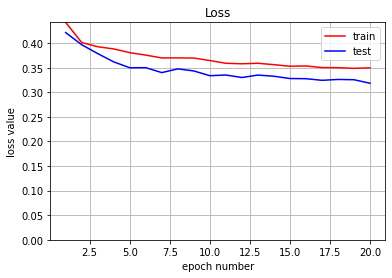

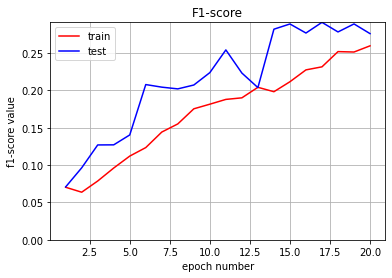

NameError: ignored

In [0]:
criterion = nn.BCELoss()
model = ConvNet()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

threshold = 0.5
n_epoch = 20
n_classes = len(classes)

train_loss = np.zeros((n_epoch))
train_score = np.zeros((n_epoch))
train_score_per_class = {i:[] for i in range(n_classes)}
test_loss = np.zeros((n_epoch))
test_score = np.zeros((n_epoch))
test_score_per_class = {i:[] for i in range(n_classes)}
best_score = 0.0

for e in range(n_epoch):
  print("*********************************")
  print("EPOCH #", e)
  train_loss[e], train_score[e], train_score_per_class[e] = train(model, device, train_loader, optimizer, criterion, threshold, n_classes)
  test_loss[e], test_score[e], test_score_per_class[e] = test(model, device, test_loader, criterion, threshold, n_classes)

  if test_score[e] > best_score:
    best_score = test_score[e]
    torch.save(model.state_dict(), 'drive/My Drive/convnet.pth')
    #torch.save({'epoch': epoch, 
    #            'model_state_dict': model.state_dict(), 
    #            'optimizer_state_dict': optimizer.state_dict(), '
    #            loss': loss}, 'drive/My Drive/Audio analytics/convnet.pth')


plot(train_loss, test_loss, n_epoch, title='Loss', ylabel='loss value')
plot(train_score, test_score, n_epoch, title='F1-score', ylabel='f1-score value')

score_per_class(classes, train_score_per_class, test_score_per_class, n_epoch)

### Draft